---
#***Graded Challenge 7***

---
# i. Introduction
- Nama  : Vicky Belario
- Batch : 017 HCK

Graded Challenge 7 ini dilakukan untuk mengimplementasikan konsep Deep Learning terutama Convolutional Neural Network dengan model Computer Vision pada dataset Land use scene

### **Objective**
- Memahami konsep Computer Vision.
- Dapat mempersiapkan data untuk digunakan dalam model Computer Vision.
- Bisa menerapkan Convolutional Neural Network dengan pada dataset Land use scene.
- Sanggup melakukan analisis  dan menjelaskan performansi dari arsitektur Convolutional Neural Network.
- Mampu melakukan Model Deployment.

---

### **Background**

Land use scene classification adalah tugas penting dalam bidang penginderaan jauh dan geographic information systems (GIS). Dengan perkembangan pesat daerah perkotaan meningkatkan manajemen lahan yang efisien dari gambar satelit menjadi sangat penting. Metode tradisional dalam klasifikasi penggunaan lahan sering melibatkan interpretasi manual, yang memakan waktu dan rentan terhadap kesalahan manusia. Namun, kemajuan dalam deep learning, khususnya Convolutional Neural Networks (CNN), telah menunjukkan kemajuan signifikan dalam mengotomatisasi dan meningkatkan akurasi tugas ini.

### **Goal**

Tujuan dari proyek ini adalah memanfaatkan Computer Vision untuk mengembangkan model dalam klasifikasi scene penggunaan lahan. Dengan demikian, sehingga berkontribusi pada praktik perencanaan perkotaan yang lebih baik dan manajemen lahan yang lebih efektif. implementasi proyek ini dapat membuka jalan bagi inovasi lebih lanjut dalam bidang remote sensing dan environmental monitoring.

---

***pengambilan data melalui website kaggle berikut: https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification/data*** <br>

***deployment proyek model pada website huggingface berikut: https://huggingface.co/spaces/vickybelario/Graded_Challenge_7***

---

### **Dataset Overview**

Dataset ini berisi citra satelit dari 21 kelas seperti bangunan, lapangan bisbol, jalan tol, dll. Dataset citra penggunaan lahan ini dimaksudkan untuk keperluan penelitian. Ukuran asli dari gambar-gambar ini adalah 256x256 piksel. Awalnya ada 100 gambar per kelas. Setelah melakukan augmentasi pada setiap gambar sebanyak 4 kali, ukuran setiap kelas meningkat menjadi 500 gambar. Ini memungkinkan untuk membuat model yang lebih kuat.

Gambar-gambar ini secara manual diekstraksi dari gambar besar koleksi USGS National Map Urban Area Imagery untuk berbagai area perkotaan di seluruh negeri. Resolusi piksel dari citra domain publik ini adalah 1 foot.

---

# ii. Import Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from google.colab import files
from pathlib import Path

import tensorflow as tf

from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.models import Sequential, load_model, Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, SpatialDropout2D, BatchNormalization

from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy

from tensorflow.keras.regularizers import l2,l1

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# iii. Data Loading

In [2]:
!kaggle datasets download -d apollo2506/landuse-scene-classification

Dataset URL: https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification
License(s): CC0-1.0
100% 1.98G/1.98G [01:31<00:00, 23.4MB/s]
100% 1.98G/1.98G [01:31<00:00, 23.4MB/s]


In [3]:
!unzip -q /content/landuse-scene-classification.zip

ImageDataGenerator dan Rescaling  Tiga generator data (train_data_img, val_data_img, test_data_img) diinisialisasi dengan parameter rescale=1./255. untuk mengubah nilai piksel dari rentang 0-255 menjadi 0-1, mempermudah proses pelatihan model.

train_img Generator untuk data pelatihan diarahkan ke direktori /content/images_train_test_val/train/, dengan ukuran target gambar 256x256 piksel, mode kelas categorical untuk label multi-kategori, dan ukuran batch 32. shuffle=False menandakan bahwa data tidak diacak.

val_img Generator untuk data validasi, mengarah ke direktori yang sama, dengan pengaturan serupa seperti data pelatihan.

test_img Generator untuk data pengujian, juga mengarah ke direktori yang sama, dengan pengaturan yang serupa seperti generator sebelumnya.

In [4]:
train_data_img = ImageDataGenerator(rescale=1./255.)
val_data_img = ImageDataGenerator(rescale=1./255.)
test_data_img = ImageDataGenerator(rescale=1./255.)

train_img = train_data_img.flow_from_directory(
	"/content/images_train_test_val/train/",
	target_size=(256,256),
	class_mode='categorical',
  batch_size=32,
	shuffle=False
)

val_img = val_data_img.flow_from_directory(
	"/content/images_train_test_val/validation/",
	target_size=(256,256),
	class_mode='categorical',
  batch_size=32,
	shuffle=False
)

test_img = test_data_img.flow_from_directory(
	"/content/images_train_test_val/test/",
	target_size=(256,256),
	class_mode='categorical',
  batch_size=32,
	shuffle=False
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [5]:
print(train_img.class_indices)
print(val_img.class_indices)
print(test_img.class_indices)

{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}
{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}
{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'ov

# iv. Exploratory Data Analysis (EDA)

menghasilkan tampilan visual dari beberapa gambar yang dipilih secara acak dari dataset latihan, membantu dalam memahami jenis data yang terdapat dalam dataset tersebut.

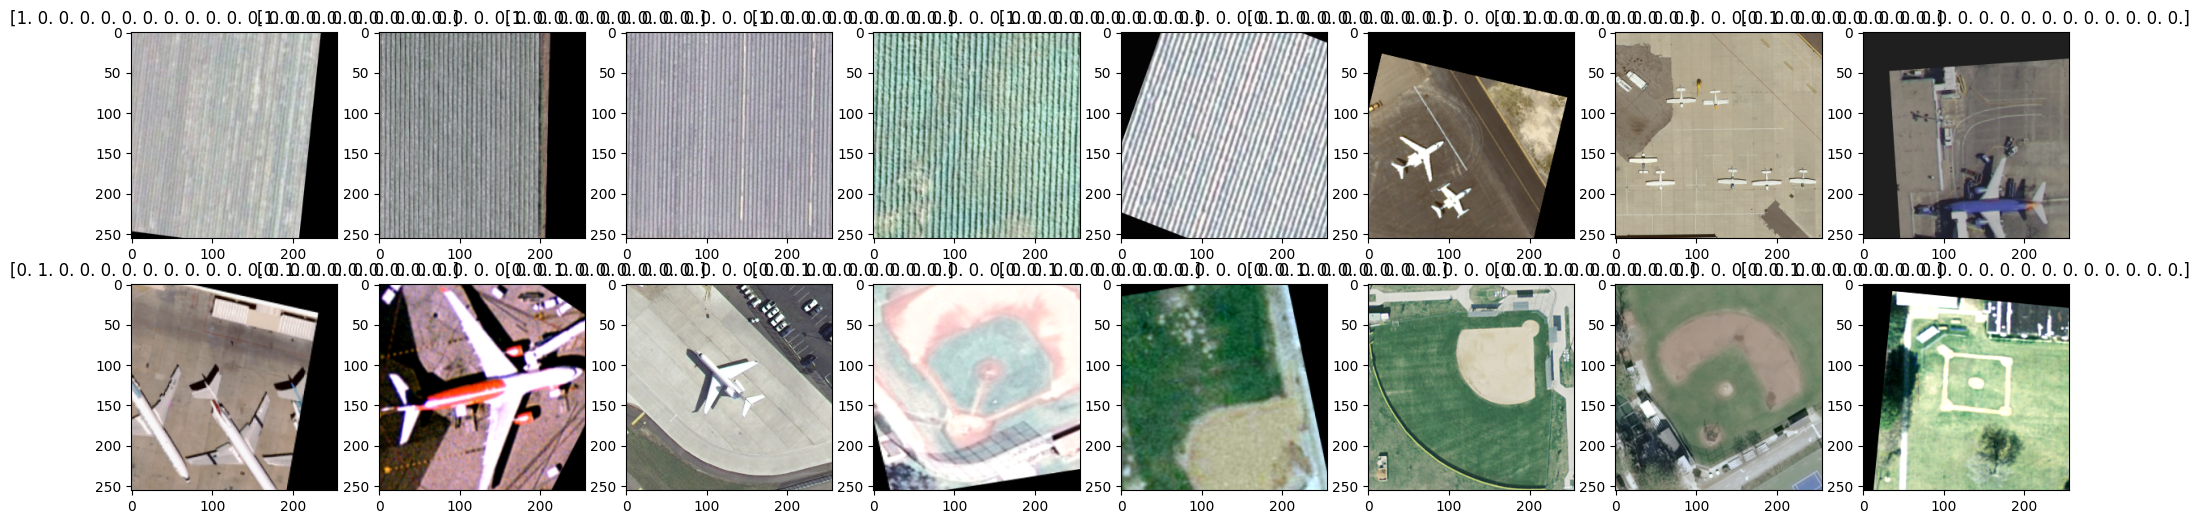

In [6]:
# Menampilkan gambar pelatihan
fig,ax = plt.subplots(nrows=2,ncols=8,figsize=(25,6)) # Membuat subplot dengan 2 baris dan 8 kolom
n = 0
# Mendapatkan satu batch data
idx = np.random.randint(len(train_img.next()[0]), size=16) # Memilih 16 gambar secara acak
for i in range(2):
  for j in range(8):
    img = train_img.next()[0][idx[n]]
    ax[i][j].imshow(img) # Menampilkan gambar
    ax[i][j].set_title(str(train_img.next()[1][idx[n]])) # Menetapkan judul dengan label
    ax[i][j].axis('off')  # Menyembunyikan sumbu
    n+=1

Fungsi collect_one_image_per_class mengambil satu gambar dari setiap kelas dalam dataset gambar yang diberikan. Ini dilakukan dengan mengulangi generator data (data_gen) untuk mengumpulkan satu gambar dari setiap kelas (class_names). Hasilnya adalah collected_images yang berisi satu gambar dari setiap kelas dan collected_labels yang berisi labelnya.

Fungsi plot_collected_images digunakan untuk memplot gambar-gambar yang telah dikumpulkan (collected_images) dalam bentuk grid, dengan judul setiap gambar sesuai dengan nama kelasnya. Parameter images_per_row menentukan berapa banyak gambar yang ditampilkan dalam satu baris.

Dengan menggunakan dua fungsi ini bersama-sama, dapat mengumpulkan dan memvisualisasikan satu contoh gambar dari setiap kelas dalam dataset untuk pemahaman visual yang lebih baik tentang konten dataset.

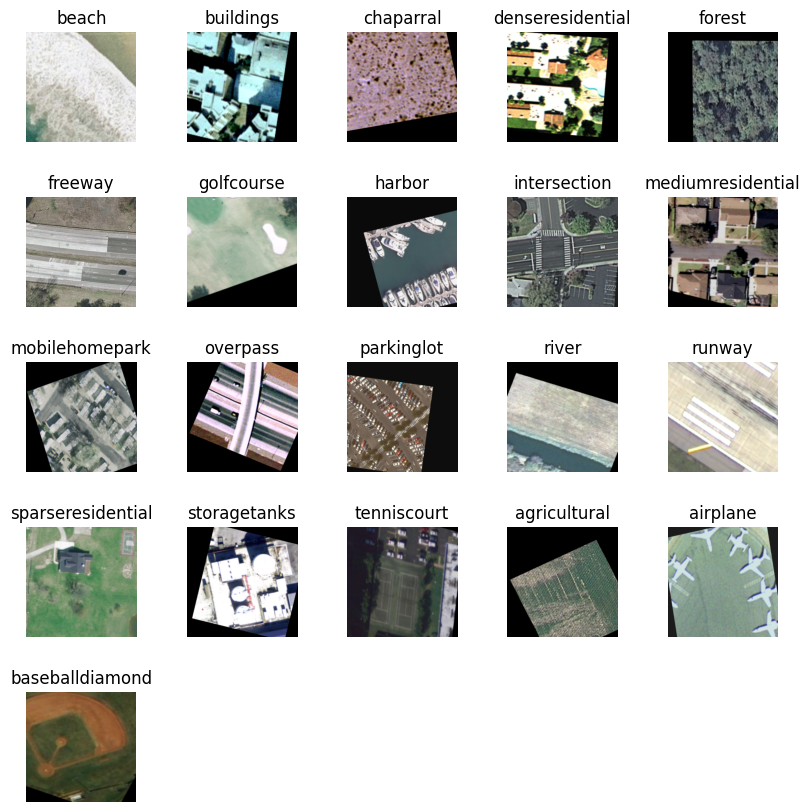

In [7]:
# Fungsi untuk mengumpulkan satu gambar per kelas
def collect_one_image_per_class(data_gen, class_names):
    class_count = len(class_names)
    collected_images = {}
    collected_labels = {}

    while len(collected_images) < class_count:
        images, labels = data_gen.next() # Mengambil batch gambar dan label dari generator
        for img, lbl in zip(images, labels):
            label_index = np.argmax(lbl) # Mendapatkan indeks label
            class_name = class_names[label_index] # Mendapatkan nama kelas dari indeks label
            if class_name not in collected_images:
                collected_images[class_name] = img # Menyimpan gambar jika belum ada di koleksi
                collected_labels[class_name] = lbl # Menyimpan label jika belum ada di koleksi
            if len(collected_images) >= class_count:
                break

    return collected_images, collected_labels

# Fungsi untuk memplot gambar yang dikumpulkan
def plot_collected_images(collected_images, collected_labels, class_names, images_per_row=5):
    n_data = len(collected_images)
    n_rows = int(np.ceil(n_data / images_per_row))
    n_cols = images_per_row
    plt.figure(figsize=(n_cols * 2, n_rows * 2))

    for idx, (class_name, img) in enumerate(collected_images.items()):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img) # Menampilkan gambar
        plt.axis('off') # Menonaktifkan sumbu
        plt.title(class_name, fontsize=12)  # Menetapkan judul dengan nama kelas

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Daftar nama kelas
class_names = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
               'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
               'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass',
               'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']

# Mengumpulkan satu gambar per kelas dari train_img
collected_images, collected_labels = collect_one_image_per_class(train_img, class_names)

# Memplot gambar yang dikumpulkan
plot_collected_images(collected_images, collected_labels, class_names, images_per_row=5)


# v. Augmentation Data (Feature Engineering)

# vi. CNN Training (Sequential API/Functional API)

## vi.1. Model Definition

- Sequential Model digunakan untuk membuat model neural network secara berurutan, dimana layer-layer ditambahkan satu per satu.

- Layer konvolusi pertama dengan 32 filter, masing-masing berukuran kernel 3x3, menggunakan aktivasi ReLU. input_shape=(256, 256, 3) menentukan bentuk input gambar dengan resolusi 256x256 piksel dan 3 channel warna (RGB).

- AveragePooling2D Layer pooling untuk mereduksi ukuran gambar dengan menggunakan metode average pooling berukuran 2x2.

- Dua blok konvolusi dan pooling berikutnya (Conv2D dan AveragePooling2D) dengan parameter yang serupa, tetapi dengan jumlah filter yang meningkat (64 dan 128), bertujuan untuk mengekstraksi fitur yang lebih kompleks dari gambar.

- GlobalAveragePooling2D Mengubah output dari lapisan konvolusi menjadi vektor satu dimensi dengan merata-ratakan setiap fitur spasial di seluruh area gambar. Ini membantu mengurangi jumlah parameter yang diperlukan untuk pelatihan dan menghindari overfitting.

- Layer Dropout untuk mengurangi overfitting dengan menghapus secara acak 50% dari unit-unit selama pelatihan.

In [8]:
cnn_train = tf.keras.models.Sequential()  # Membuat model Sequential

cnn_train.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))# Menambahkan layer konvolusi dengan 32 filter, ukuran kernel 3x3, dan aktivasi ReLU
cnn_train.add(tf.keras.layers.AveragePooling2D(2, 2))# Menambahkan layer pooling dengan ukuran pool 2x2

cnn_train.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))# Menambahkan layer konvolusi dengan 64 filter, ukuran kernel 3x3, dan aktivasi ReLU
cnn_train.add(tf.keras.layers.AveragePooling2D(2, 2))# Menambahkan layer pooling dengan ukuran pool 2x2

cnn_train.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))# Menambahkan layer konvolusi dengan 128 filter, ukuran kernel 3x3, dan aktivasi ReLU
cnn_train.add(tf.keras.layers.AveragePooling2D(2, 2))# Menambahkan layer pooling dengan ukuran pool 2x2

cnn_train.add(tf.keras.layers.GlobalAveragePooling2D())# Menambahkan layer Global Average Pooling
cnn_train.add(tf.keras.layers.Dropout(0.5))# Menambahkan layer Dropout dengan dropout rate 0.5

cnn_train.add(tf.keras.layers.Dense(512, activation='relu'))# Menambahkan layer Dense dengan 512 unit dan aktivasi ReLU

cnn_train.add(tf.keras.layers.Dense(21, activation='softmax'))# Menambahkan layer Dense dengan 21 unit (jumlah kelas) dan aktivasi softmax



cnn_train.compile Ini mengonfigurasi model untuk pelatihan dengan menentukan tiga komponen utama

- Fungsi loss digunakan untuk mengukur seberapa baik model memprediksi label kelas. categorical_crossentropy cocok untuk masalah klasifikasi multi-kelas.

- optimizer Adam digunakan untuk menyesuaikan bobot model berdasarkan data pelatihan. Adam adalah optimizer yang sering digunakan karena efisiensinya dalam pelatihan neural network.

- accuracy Metrik evaluasi digunakan selama pelatihan dan pengujian model, menggunakan akurasi untuk melihat seberapa sering model memprediksi dengan benar.

cnn_train.summary() Ini menampilkan ringkasan arsitektur model, Ringkasan ini memberikan gambaran yang jelas tentang struktur dan ukuran model yang telah dibangun.

In [9]:
# Mengkompilasi model
cnn_train.compile(
    loss='categorical_crossentropy',  # Menggunakan loss function categorical crossentropy
    optimizer='Adam',  # Menggunakan optimizer Adam
    metrics=['accuracy']  # Menggunakan metric akurasi
)

# Menampilkan ringkasan arsitektur model
cnn_train.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 average_pooling2d (Average  (None, 127, 127, 32)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 62, 62, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 30, 30, 128)       0

## vi.2. Model Training

Data Pelatihan (train_img) Ini adalah generator data yang berisi gambar-gambar untuk pelatihan model. Generator ini akan memberikan batch-batch gambar kepada model selama pelatihan.

Data Validasi (val_img) Ini adalah generator data yang digunakan untuk mengevaluasi model pada setiap epoch untuk memastikan bahwa model tidak overfit.

- Epochs Parameter menentukan jumlah 25 kali model akan melihat seluruh dataset pelatihan selama proses pelatihan.

- Batch Size menunjukkan 32 banyak sampel gambar yang akan digunakan dalam setiap iterasi pelatihan. Ini mempengaruhi kecepatan dan stabilitas pelatihan.

- Verbose mengatur apakah ingin melihat output pelatihan selama proses berlangsung. Nilai 1 berarti mencetak output pada setiap epoch.


In [10]:
# Melatih model
history1 = cnn_train.fit(
    train_img,  # Data pelatihan
    epochs=25,  # Jumlah epoch
    batch_size=32,  # Ukuran batch
    steps_per_epoch=20,  # Jumlah langkah per epoch
    validation_data=val_img,  # Data validasi
    verbose=1,  # Menampilkan output pelatihan
    validation_steps=10  # Jumlah langkah validasi per epoch
)


Epoch 1/25
20/20 [==============================] - 13s 211ms/step - loss: 3.0629 - accuracy: 0.0938 - val_loss: 2.9899 - val_accuracy: 0.0000e+00
Epoch 2/25
20/20 [==============================] - 6s 294ms/step - loss: 3.0665 - accuracy: 0.0500 - val_loss: 3.0214 - val_accuracy: 0.0000e+00
Epoch 3/25
20/20 [==============================] - 5s 262ms/step - loss: 3.0345 - accuracy: 0.0000e+00 - val_loss: 3.0172 - val_accuracy: 0.0000e+00
Epoch 4/25
20/20 [==============================] - 5s 273ms/step - loss: 3.0179 - accuracy: 0.0672 - val_loss: 2.9419 - val_accuracy: 0.0000e+00
Epoch 5/25
20/20 [==============================] - 5s 259ms/step - loss: 3.0958 - accuracy: 0.0234 - val_loss: 2.9868 - val_accuracy: 0.0000e+00
Epoch 6/25
20/20 [==============================] - 6s 297ms/step - loss: 3.0597 - accuracy: 0.0516 - val_loss: 3.0146 - val_accuracy: 0.0000e+00
Epoch 7/25
20/20 [==============================] - 6s 308ms/step - loss: 3.0555 - accuracy: 0.0437 - val_loss: 3.0286 

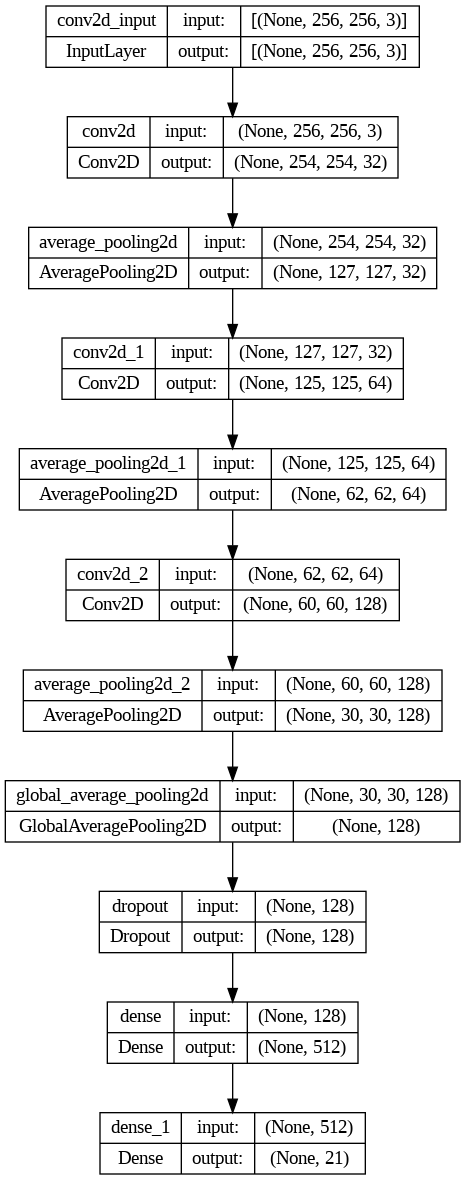

In [11]:
# Menampilkan struktur model
tf.keras.utils.plot_model(cnn_train, show_shapes=True)  # Menampilkan bentuk setiap layer pada model

## vi.3. Model Evaluation

In [44]:
test_loss1, test_accuracy1 = cnn_train.evaluate(test_img, batch_size=32)

33/33 [==============================] - 5s 141ms/step - loss: 3.0498 - accuracy: 0.0476


In [45]:
print(f"Test Loss:     {test_loss1}")
print(f"Test Accuracy: {test_accuracy1}")

Test Loss:     3.049786329269409
Test Accuracy: 0.0476190485060215


Akurasi keseluruhan hanya 0.05, yang sangat rendah dan menunjukkan bahwa model hanya benar dalam 5% dari kasus.


In [46]:
# Mendapatkan label sebenarnya dari train_img
true_labels1 = train_img.classes

# Memastikan prediksi sesuai dengan batch-batch train_img
predictions1 = cnn_train.predict(train_img)
predicted_labels1 = np.argmax(predictions1, axis=1)


230/230 [==============================] - 30s 130ms/step


In [47]:
# Menghasilkan laporan klasifikasi
laporan = classification_report(true_labels1, predicted_labels1, target_names=class_names)

# Menampilkan laporan klasifikasi
print('-'*30, 'Hasil Uji', '-'*30)
print(laporan)


------------------------------ Hasil Uji ------------------------------
                   precision    recall  f1-score   support

     agricultural       0.00      0.00      0.00       350
         airplane       0.05      1.00      0.09       350
  baseballdiamond       0.00      0.00      0.00       350
            beach       0.00      0.00      0.00       350
        buildings       0.00      0.00      0.00       350
        chaparral       0.00      0.00      0.00       350
 denseresidential       0.00      0.00      0.00       350
           forest       0.00      0.00      0.00       350
          freeway       0.00      0.00      0.00       350
       golfcourse       0.00      0.00      0.00       350
           harbor       0.00      0.00      0.00       350
     intersection       0.00      0.00      0.00       350
mediumresidential       0.00      0.00      0.00       350
   mobilehomepark       0.00      0.00      0.00       350
         overpass       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- model memprediksi hampir semua gambar sebagai airplane, meskipun banyak dari prediksi tersebut salah. 
- model training banyak melakukan kesalahan dalam memprediksi label atau class

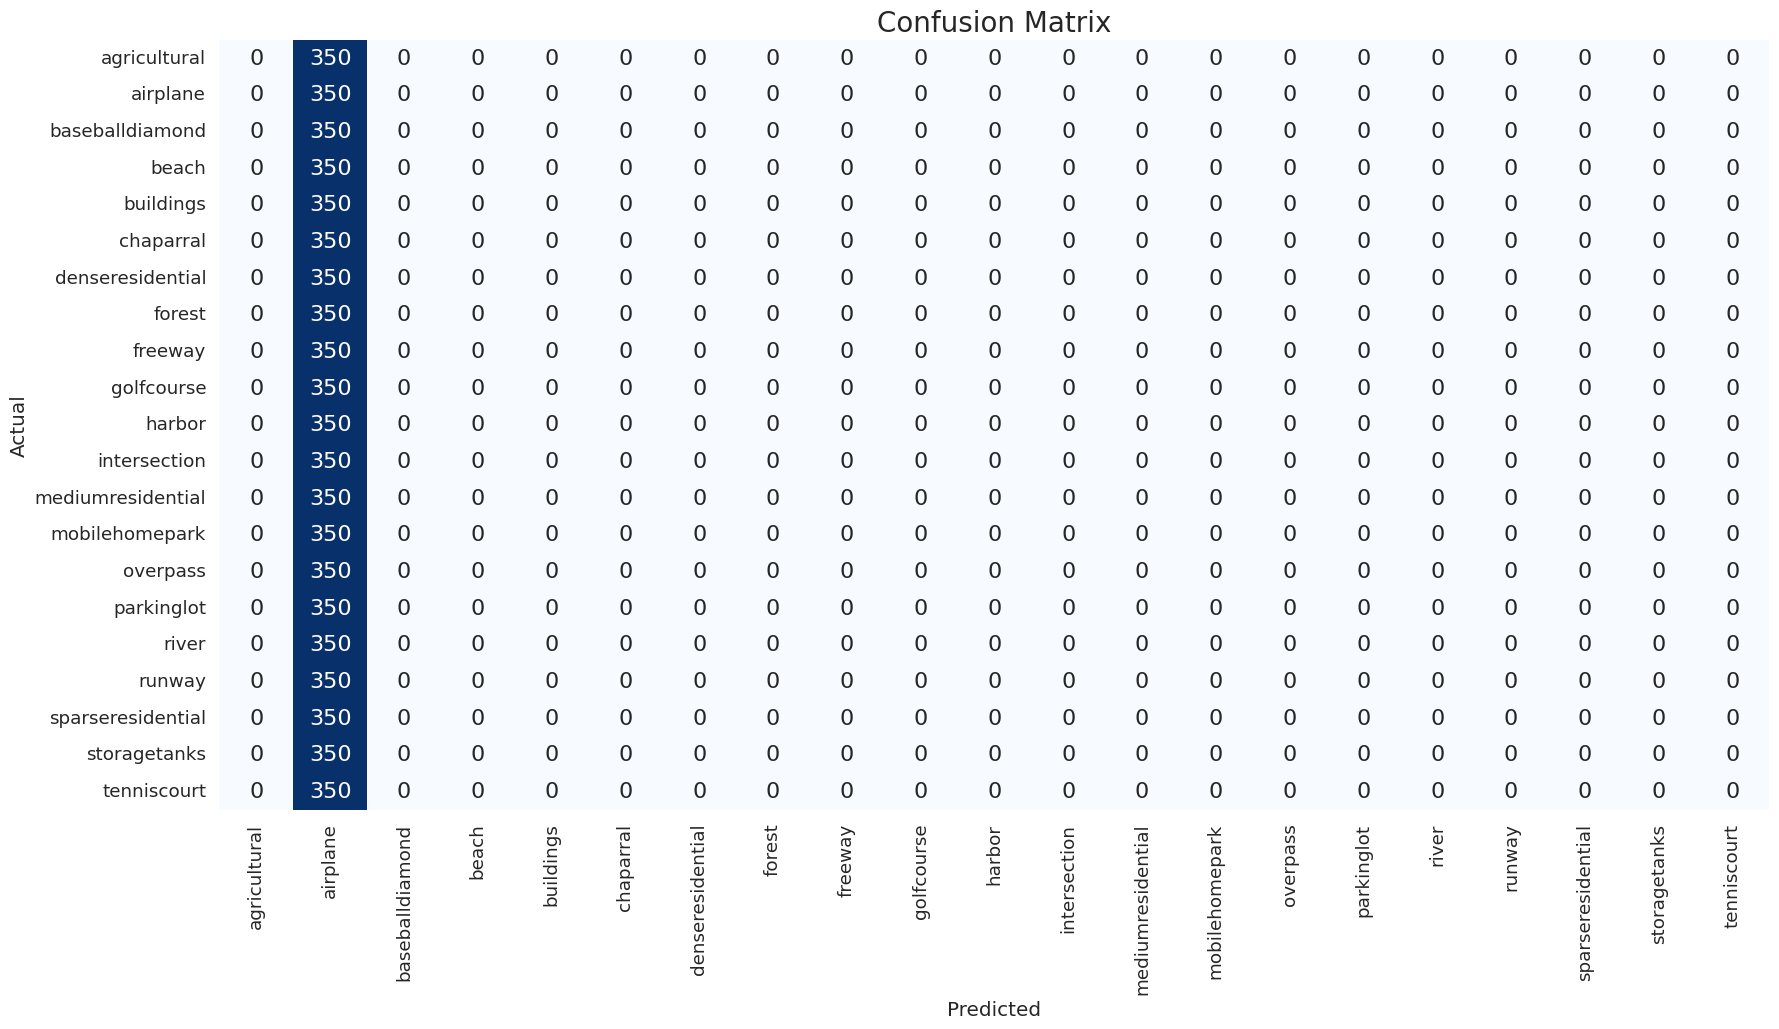

In [49]:

# Menghasilkan dan menampilkan confusion matriks
conf_matrix = confusion_matrix(true_labels1, predicted_labels1)
cm = pd.DataFrame(conf_matrix, columns=class_names, index=class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(20,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

plt.show()



terlihat dari matrics confusion model training  hampir semua label atau class nya mengalami gagal prediksi 

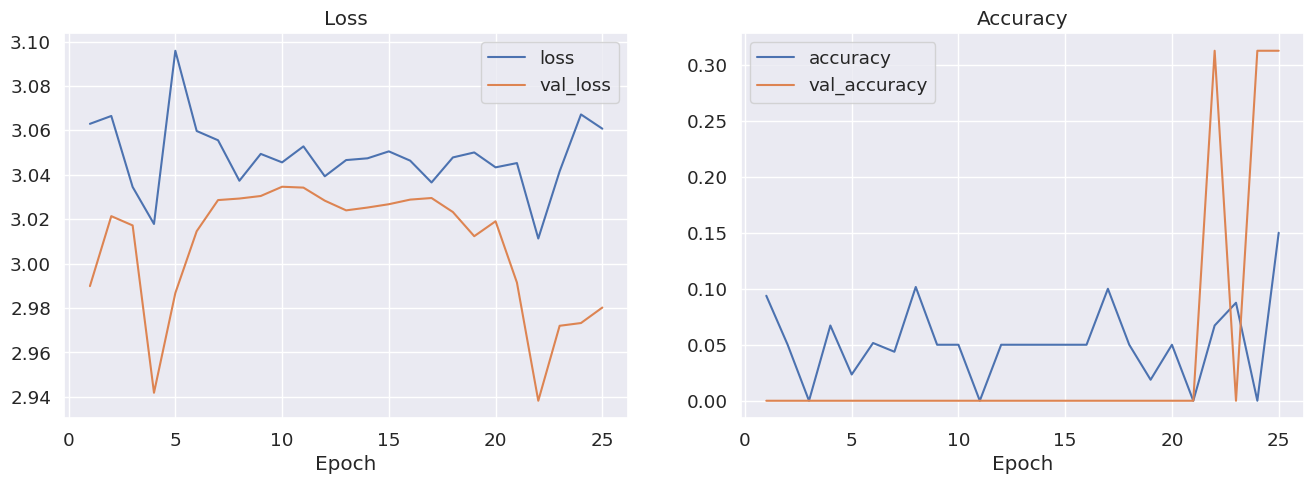

In [48]:
epoch=25

fig, ax = plt.subplots(ncols=2, figsize=(16,5))

# Plot Loss
ax[0].plot(range(1, epoch+1), history1.history['loss'], label='loss')  # Plot nilai loss selama training
ax[0].plot(range(1, epoch+1), history1.history['val_loss'], label='val_loss')  # Plot nilai loss selama validation
ax[0].set_title('Loss')  # Menambahkan judul pada plot loss
ax[0].legend()  # Menampilkan legenda pada plot loss
ax[0].set_xlabel('Epoch')  # Menambahkan label pada sumbu x plot loss

# Plot Accuracy
ax[1].plot(range(1, epoch+1), history1.history['accuracy'], label='accuracy')  # Plot nilai accuracy selama training
ax[1].plot(range(1, epoch+1), history1.history['val_accuracy'], label='val_accuracy')  # Plot nilai accuracy selama validation
ax[1].set_title('Accuracy')  # Menambahkan judul pada plot accuracy
ax[1].legend()  # Menampilkan legenda pada plot accuracy
ax[1].set_xlabel('Epoch')  # Menambahkan label pada sumbu x plot accuracy

plt.show()  # Menampilkan plot


berdasarkan line plot
- accuracy mengalami kenaikan di akhir epoch tetapi accuracy masih terlalu kecil untuk model cnn training
- loss pada data training secara konsisten lebih tinggi daripada loss pada data validasi(val_loss), mengindikasikan model sedang mengalami underfitting. Underfitting terjadi ketika model terlalu sederhana untuk menangkap pola yang mendasari pada data training.


maka dari itu dibuat cnn improvement untuk mengatasi loss

# vii. CNN Improvement (Sequential API/Functional API)

## vii.1. Model Definition


- Menambahkan layer konvolusi dengan 32 filter, masing-masing berukuran kernel 3x3, menggunakan aktivasi ReLU. Initialisasi HeNormal digunakan untuk inisialisasi bobot dengan mempertimbangkan faktor dari ReLU. input_shape=(256, 256, 3) menentukan bentuk input gambar dengan resolusi 256x256 piksel dan 3 channel warna (RGB).

- BatchNormalization Menambahkan normalisasi batch setelah setiap lapisan konvolusi untuk mempercepat proses pelatihan dan mengurangi overfitting.

- MaxPooling2D Menambahkan layer MaxPooling 2D untuk mereduksi ukuran fitur dengan menggunakan pool 2x2.

- layers.SpatialDropout2D Menambahkan Spatial Dropout untuk mengurangi korelasi spasial antar fitur dengan dropout rate 0.2.

- Pada lapisan konvolusi ke-2 dan ke-3 (Conv2D),  menggunakan regularisasi L2 (tf.keras.regularizers.l2(0.001)) untuk mencegah overfitting dengan menambahkan penalty pada bobot model.

- Flatten Mengubah output dari lapisan konvolusi menjadi vektor satu dimensi untuk digunakan dalam lapisan-lapisan Dense.

- Menambahkan tiga lapisan Dense (sepenuhnya terhubung) dengan aktivasi ReLU. Ini bertujuan untuk memproses fitur-fitur yang telah diekstraksi menjadi representasi yang lebih abstrak. Dropout juga digunakan pada beberapa lapisan Dense untuk mengurangi overfitting.


In [16]:
# Menghapus sesi sebelumnya

seed = 20
tf.keras.backend.clear_session()  # Menghapus sesi backend Keras untuk memulai dari awal
np.random.seed(seed)  # Mengatur seed untuk numpy
tf.random.set_seed(seed)  # Mengatur seed untuk TensorFlow

# Membuat model Sequential
cnn_improve = tf.keras.models.Sequential()

# Menambahkan lapisan Convolutional 2D dengan 32 filter, aktivasi ReLU, initialisasi HeNormal, dan input shape 256x256 piksel dengan 3 channel warna
cnn_improve.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed), input_shape=(256, 256, 3)))
cnn_improve.add(tf.keras.layers.MaxPooling2D(2, 2))  # Menambahkan MaxPooling 2D
cnn_improve.add(tf.keras.layers.SpatialDropout2D(0.2))  # Menambahkan Spatial Dropout

# Menambahkan lapisan Convolutional 2D dengan 64 filter, aktivasi ReLU dan MaxPooling 2D
cnn_improve.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
cnn_improve.add(tf.keras.layers.MaxPooling2D(2, 2))
cnn_improve.add(tf.keras.layers.SpatialDropout2D(0.2))

# Menambahkan lapisan Convolutional 2D dengan 128 filter, aktivasi ReLU dan MaxPooling 2D
cnn_improve.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
cnn_improve.add(tf.keras.layers.MaxPooling2D(2, 2))
cnn_improve.add(tf.keras.layers.SpatialDropout2D(0.2))

# Meratakan output menjadi satu dimensi
cnn_improve.add(tf.keras.layers.Flatten())

# Menambahkan normalisasi batch
cnn_improve.add(tf.keras.layers.BatchNormalization())
cnn_improve.add(tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn_improve.add(tf.keras.layers.Dropout(0.2,seed=seed))

# Menambahkan normalisasi batch
cnn_improve.add(tf.keras.layers.BatchNormalization())
cnn_improve.add(tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn_improve.add(tf.keras.layers.Dropout(0.2,seed=seed))

# Menambahkan normalisasi batch
cnn_improve.add(tf.keras.layers.BatchNormalization())
cnn_improve.add(tf.keras.layers.Dense(128, activation='relu'))

# Output layer dengan aktivasi softmax untuk klasifikasi multi-kelas
cnn_improve.add(tf.keras.layers.Dense(21, activation='softmax'))


- Menambahkan EarlyStopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam akurasi pelatihan setelah 5 epoch berturut-turut. restore_best_weights=True mengembalikan bobot model ke yang terbaik selama proses pelatihan.

- Membuat jadwal penurunan learning rate secara eksponensial. initial_learning_rate=0.1 menunjukkan learning rate awal, decay_steps=1000 adalah langkah-langkah penurunan, dan decay_rate=0.9 adalah tingkat penurunan.

- Menambahkan LearningRateScheduler untuk menyesuaikan learning rate model berdasarkan jadwal yang telah ditentukan.


In [17]:

# Menggunakan optimizer Adam dengan learning rate 0.001 dan gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)
cnn_improve.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# menambahkan EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# menambahkan Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1, decay_steps=1000, decay_rate=0.9)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch))


# Menampilkan ringkasan arsitektur model
cnn_improve.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 spatial_dropout2d (Spatial  (None, 127, 127, 32)      0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                        

## vii.2. Model Training

- Steps per Epoch menentukan berapa banyak batch yang akan dieksekusi pada setiap epoch. len(train_img) // 32 menghitung jumlah batch berdasarkan ukuran batch yang telah ditentukan.

- Validation Steps menentukan berapa banyak batch yang akan dievaluasi pada setiap epoch saat menggunakan data validasi. len(val_img) // 32 menghitung jumlah batch validasi berdasarkan ukuran batch yang telah ditentukan.

- Callbacks digunakan untuk mengatur perilaku model selama pelatihan. EarlyStopping akan menghentikan pelatihan jika tidak ada peningkatan dalam akurasi pelatihan setelah 5 epoch berturut-turut, sementara LearningRateScheduler akan menyesuaikan learning rate model berdasarkan jadwal penurunan yang telah ditentukan.


In [18]:

history2 = cnn_improve.fit(
    train_img,   # Data pelatihan
    epochs=50,   # Jumlah epoch
    batch_size=32,   # Ukuran batch
    steps_per_epoch=len(train_img) // 32,   # Jumlah langkah per epoch
    validation_data=val_img,   # Data validasi
    validation_steps=len(val_img) // 32,   # Jumlah langkah validasi per epoch
    callbacks=[early_stopping, lr_scheduler],
    verbose=1   # Menampilkan output pelatihan
)

Epoch 1/50
7/7 [==============================] - 10s 601ms/step - loss: 1910.8981 - accuracy: 0.0000e+00 - val_loss: 5188.5293 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 2/50
7/7 [==============================] - 2s 232ms/step - loss: 3052.9314 - accuracy: 0.0000e+00 - val_loss: 2260.6443 - val_accuracy: 0.0156 - lr: 0.1000
Epoch 3/50
7/7 [==============================] - 2s 251ms/step - loss: 1630.0436 - accuracy: 0.0000e+00 - val_loss: 950.5029 - val_accuracy: 1.0000 - lr: 0.1000
Epoch 4/50
7/7 [==============================] - 2s 321ms/step - loss: 662.5130 - accuracy: 0.1429 - val_loss: 381.9682 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 5/50
7/7 [==============================] - 2s 268ms/step - loss: 278.6562 - accuracy: 0.0000e+00 - val_loss: 177.4048 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 6/50
7/7 [==============================] - 2s 308ms/step - loss: 136.5663 - accuracy: 0.0000e+00 - val_loss: 92.3412 - val_accuracy: 0.0000e+00 - lr: 0.0999
Epoch 7/50
7/7 [=

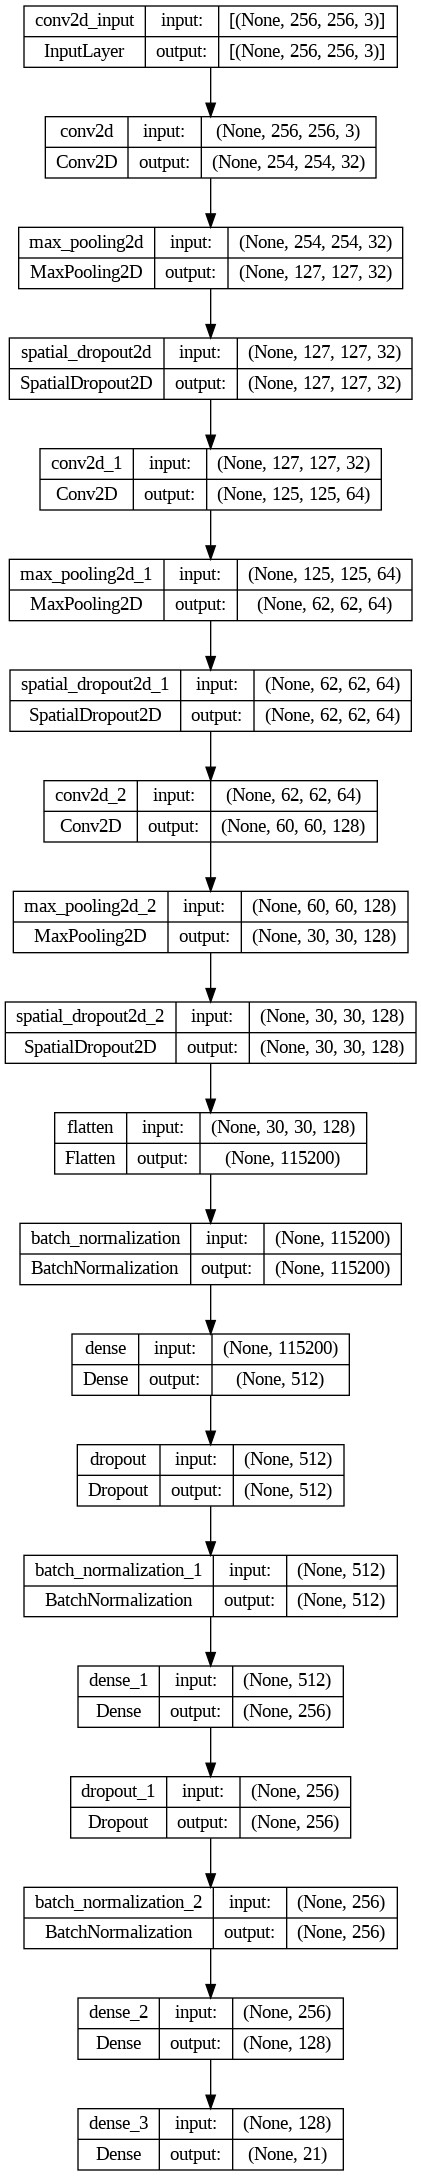

In [19]:
# Menampilkan struktur model
tf.keras.utils.plot_model(cnn_improve, show_shapes=True) # Menampilkan bentuk setiap layer pada model

## vii.3. Model Evaluation

In [38]:
test_loss2, test_accuracy2 = cnn_improve.evaluate(test_img, batch_size=32)

33/33 [==============================] - 4s 133ms/step - loss: 382.9693 - accuracy: 0.0476


In [39]:
print(f"Test Loss:     {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

Test Loss:     382.96929931640625
Test Accuracy: 0.0476190485060215


model improvement masih memiliki akurasi yang rendah

In [40]:
# Mendapatkan label sebenarnya dari test_img
true_labels2 = test_img.classes

# Memastikan prediksi sesuai dengan batch-batch test_img
predictions2 = cnn_improve.predict(test_img)
predicted_labels2 = np.argmax(predictions2, axis=1)




33/33 [==============================] - 4s 123ms/step


In [41]:
# Menghasilkan laporan klasifikasi
report = classification_report(true_labels2, predicted_labels2, target_names=class_names)

# Menampilkan laporan klasifikasi
print('-'*30, 'Test', '-'*30)
print(report)

------------------------------ Test ------------------------------
                   precision    recall  f1-score   support

     agricultural       0.00      0.00      0.00        50
         airplane       0.00      0.00      0.00        50
  baseballdiamond       0.00      0.00      0.00        50
            beach       0.00      0.00      0.00        50
        buildings       0.00      0.00      0.00        50
        chaparral       0.00      0.00      0.00        50
 denseresidential       0.00      0.00      0.00        50
           forest       0.00      0.00      0.00        50
          freeway       0.00      0.00      0.00        50
       golfcourse       0.00      0.00      0.00        50
           harbor       0.00      0.00      0.00        50
     intersection       0.00      0.00      0.00        50
mediumresidential       0.00      0.00      0.00        50
   mobilehomepark       0.00      0.00      0.00        50
         overpass       0.00      0.00      0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- sebagian besar kelas, precision, recall, dan f1-score adalah 0.00. Ini berarti model tidak dapat memprediksi kelas-kelas tersebut dengan benar.
- terlihat model cnn improve hanya bisa menebak label atau class tennis court saja

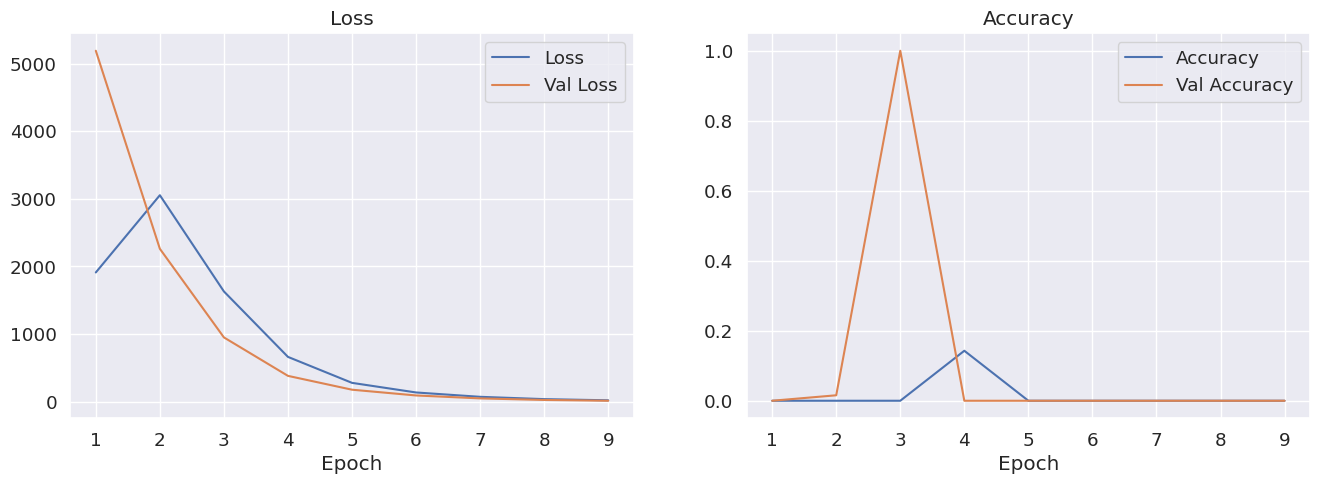

In [42]:
# Menampilkan grafik Loss dan Accuracy dari pelatihan model cnn_improve

epoch = 9

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# Plot grafik Loss
ax[0].plot(range(1, epoch+1), history2.history['loss'], label='Loss')
ax[0].plot(range(1, epoch+1), history2.history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Plot grafik Accuracy
ax[1].plot(range(1, epoch+1), history2.history['accuracy'], label='Accuracy')
ax[1].plot(range(1, epoch+1), history2.history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()



berdasarkan line plot
- accuracy mengalami sedikit kenaikan  di epoch 4 lalu kembali datar
-  val accuracy memiliki kenaikan  di epoch 3 lalu turun lagi di epoch berikutnya

berdasarkan line plot
- loss mengalami penurunan di epoch ke 2 sampai epoch ke 9
- val loss mulai tinggi di epoch 1 kemudian terus turun sampai dengan epoch 9 

loss training dan loss validasi terus menurun dan akhirnya menyentuh nilai yang hampir sama, ini menunjukkan bahwa model belajar dengan baik dan menggeneralisasi dengan baik ke data yang tidak terlihat.
Tidak Ada Overfitting atau Underfitting:

Karena loss training dan loss validasi konsisten menurun dan hampir sama di akhir, ini menunjukkan bahwa model tidak mengalami overfitting atau underfitting.


bisa disimpulkan model cnn improve lebih baik dari model cnn training dalam loss, tetapi keduanya tetap memiliki accuracy yang kecil

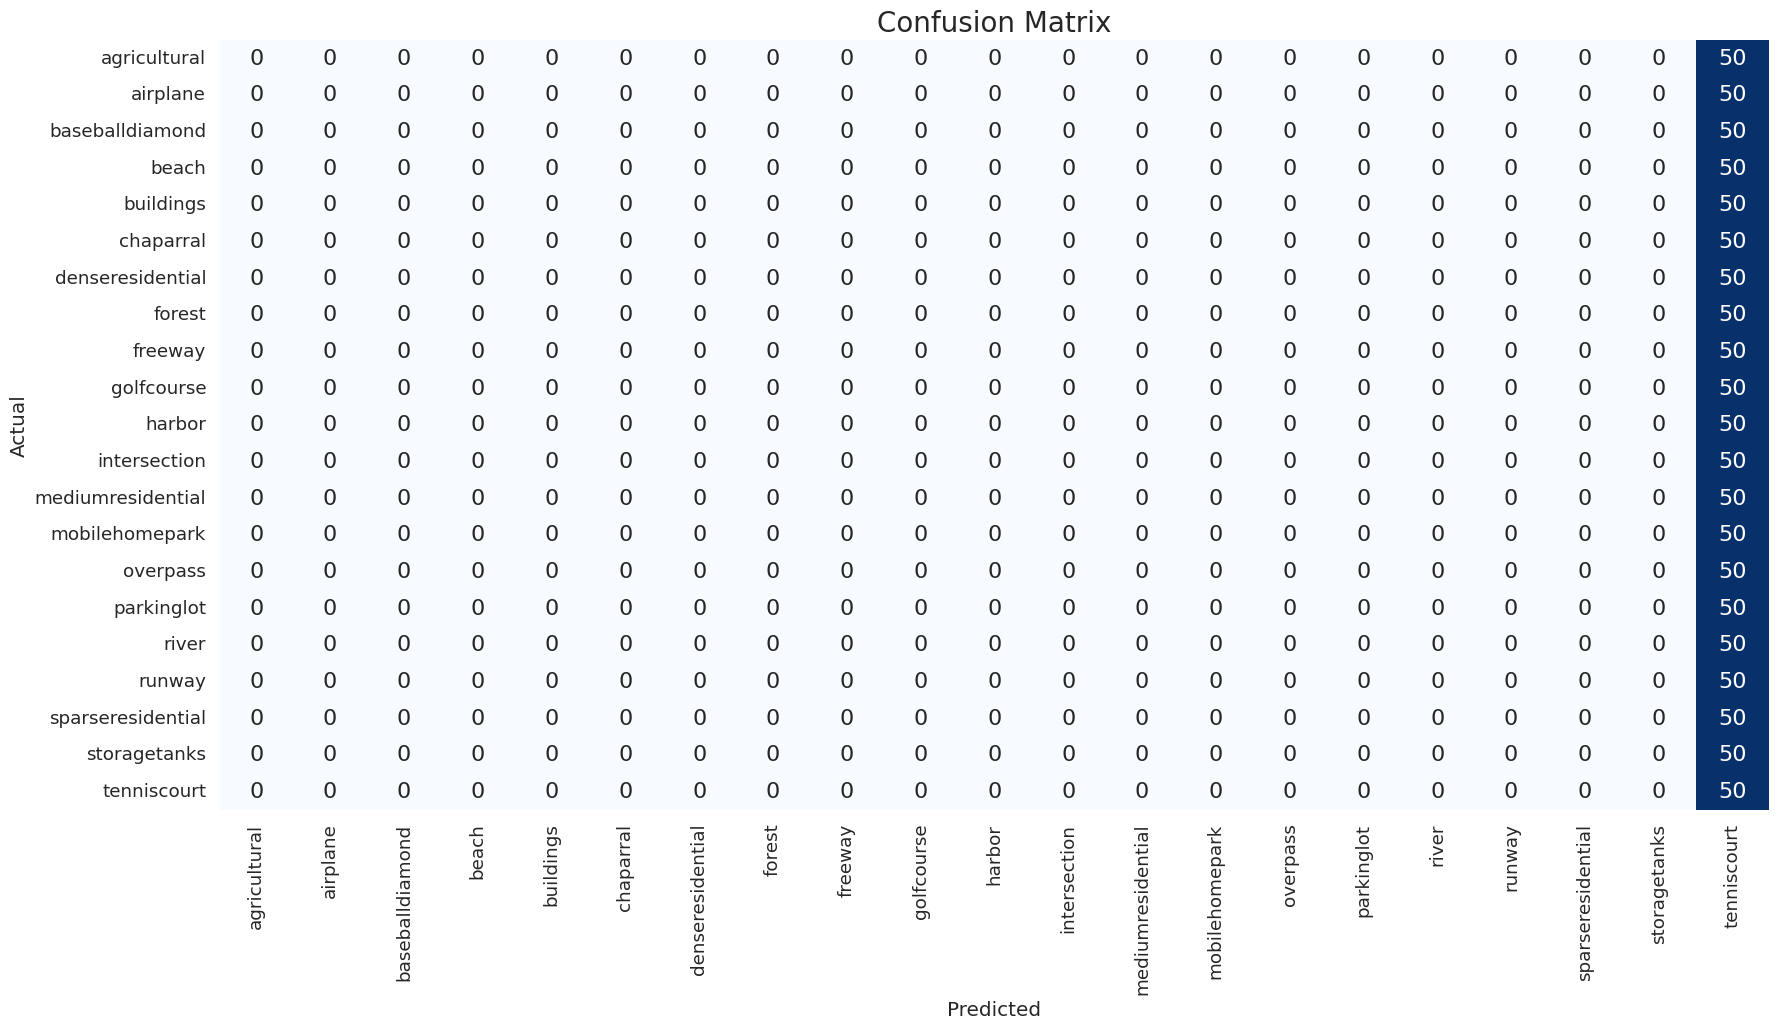

In [43]:

# Menghasilkan dan menampilkan confusion matriks
conf_matrix = confusion_matrix(true_labels2, predicted_labels2)
cm = pd.DataFrame(conf_matrix, columns=class_names, index=class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(20,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

plt.show()

karena accuracy yang kecil dari model cnn training dan cnn improve menyebabkan kedua model sama-sama melakukan prediksi yang buruk maka dilakukan transfer learning dengan menggunakan DenseNet201

# viii. Transfer Learning

## viii.1. Model Definition

In [26]:
# Load the pre-trained model without the top layer
transfer_learn = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in transfer_learn.layers:
    layer.trainable = False

# Add a new top layer for classification
x = transfer_learn.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(21, activation='softmax')(x)

74836368/74836368 [==============================] - 4s 0us/step


## viii.2. Model Training

In [27]:
# Create the new model
transfer_learning = tf.keras.models.Model(inputs=transfer_learn.input, outputs=predictions)

# Compile the model
transfer_learning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up the data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/images_train_test_val/train/', target_size=(224, 224), batch_size=32, class_mode='categorical',shuffle=False)
val_generator = val_datagen.flow_from_directory('/content/images_train_test_val/validation/', target_size=(224, 224), batch_size=32, class_mode='categorical',shuffle=False)

# Train the model
ret_model=transfer_learning.fit(train_generator, epochs=50, validation_data=val_generator)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Epoch 1/50
230/230 [==============================] - 157s 606ms/step - loss: 2.5009 - accuracy: 0.3230 - val_loss: 1.1646 - val_accuracy: 0.6176
Epoch 2/50
230/230 [==============================] - 124s 539ms/step - loss: 1.0101 - accuracy: 0.6510 - val_loss: 0.9933 - val_accuracy: 0.6629
Epoch 3/50
230/230 [==============================] - 130s 567ms/step - loss: 0.7293 - accuracy: 0.7479 - val_loss: 0.6061 - val_accuracy: 0.7824
Epoch 4/50
230/230 [==============================] - 120s 523ms/step - loss: 0.5305 - accuracy: 0.8189 - val_loss: 0.4392 - val_accuracy: 0.8519
Epoch 5/50
230/230 [==============================] - 123s 537ms/step - loss: 0.4198 - accuracy: 0.8618 - val_loss: 0.4311 - val_accuracy: 0.8405
Epoch 6/50
230/230 [==============================] - 121s 524ms/step - loss: 0.3728 - accuracy: 0.8714 - val_loss: 0.3581 - val_accuracy: 0.8724
Epoch 7/50
230/230 [==================

In [28]:
test_dataset = '/content/images_train_test_val/test/'
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (256,256),
                                                 class_mode='categorical')

Found 1050 images belonging to 21 classes.


In [29]:
class_label=list(train_generator.class_indices.keys())

In [30]:
transfer_learning.evaluate(test_generator)
preds = transfer_learning.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

33/33 [==============================] - 9s 180ms/step


## viii.3. Model Evaluation

In [36]:
test_loss, test_accuracy = transfer_learning.evaluate(test_generator, batch_size=32)

33/33 [==============================] - 6s 167ms/step - loss: 0.1058 - accuracy: 0.9686


In [37]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.1058136373758316
Test Accuracy: 0.9685714244842529


- transger learning menyelesaikan masalah akurasi pada 2 model sebelumnya
- Model dengan learning rate yang baru memiliki akurasi 0.97, yang sangat tinggi.


In [31]:
print(classification_report(y_test, y_preds))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.98      0.98        50
           2       1.00      0.94      0.97        50
           3       0.98      0.98      0.98        50
           4       0.96      0.98      0.97        50
           5       1.00      1.00      1.00        50
           6       0.93      0.78      0.85        50
           7       1.00      1.00      1.00        50
           8       0.93      1.00      0.96        50
           9       0.96      1.00      0.98        50
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.81      0.96      0.88        50
          13       0.98      0.94      0.96        50
          14       1.00      0.92      0.96        50
          15       1.00      1.00      1.00        50
          16       0.98      0.98      0.98        50
          17       0.98    

Model dengan learning rate yang baru mampu memprediksi semua kelas dengan baik, dengan precision, recall, dan f1-score hampir mendekati sempurna .

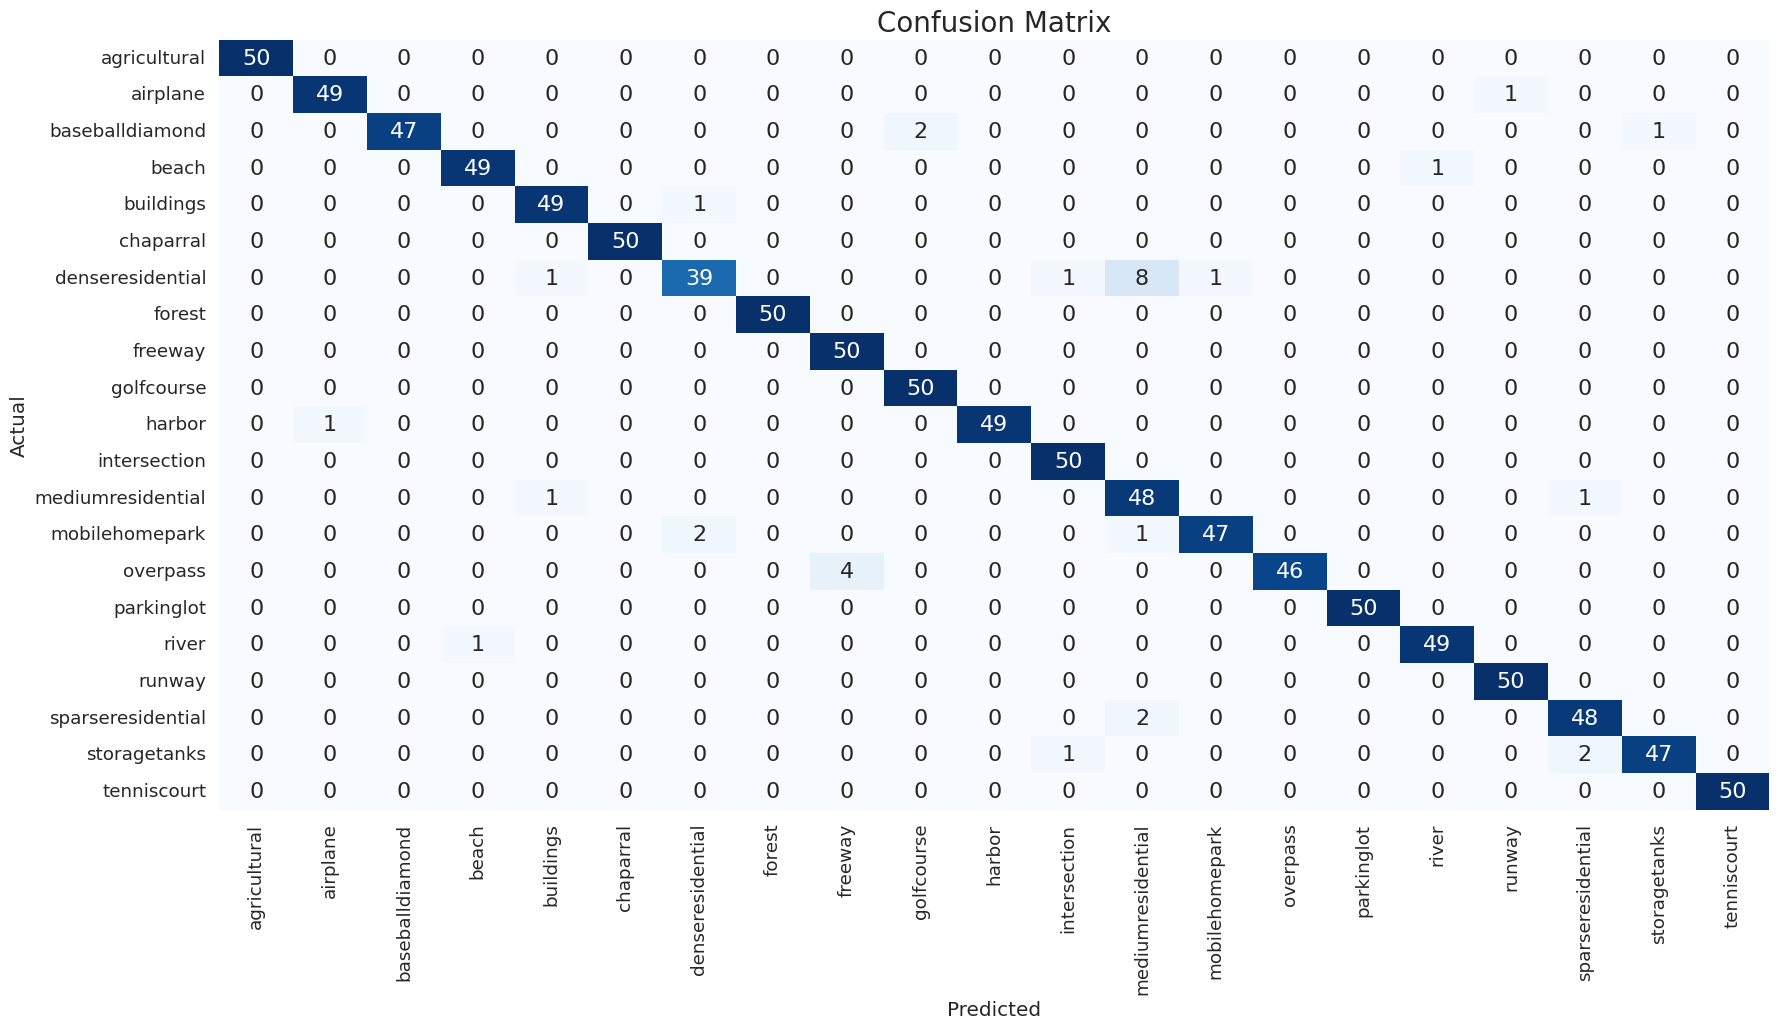

In [32]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=class_label, index = class_label)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

Model dengan learning rate yang baru menunjukkan performa yang sangat baik di semua kelas, menunjukkan bahwa model ini mampu menggeneralisasi dengan baik ke data baru.

<ipython-input-33-77ec6c303384>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')


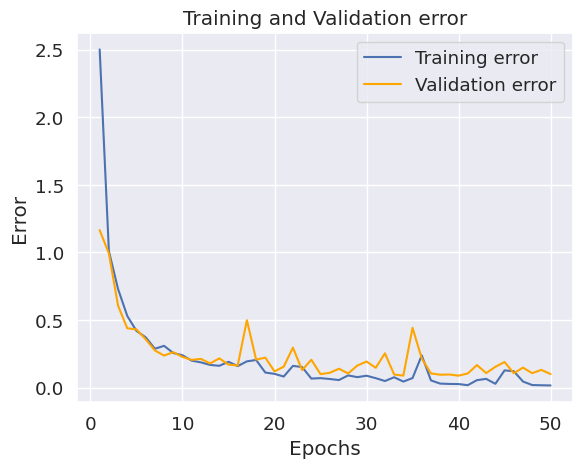

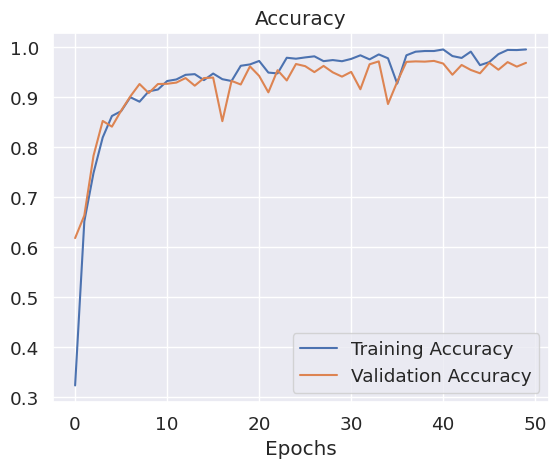

In [33]:
history_dict = ret_model.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

loss = ret_model.history['loss']
val_loss = ret_model.history['val_loss']
accuracy = ret_model.history['accuracy']
val_accuracy = ret_model.history['val_accuracy']
epochs = range(len(ret_model.history['loss']))
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# 8. Model Saving

In [34]:
transfer_learning.save('model_final.keras')

# 9. Kesimpulan

**Model CNN Training**<br>

Precision, Recall, F1-Score, Accuracy:
Hasil precision, recall, dan f1-score dari model CNN training menunjukkan bahwa model ini gagal memprediksi hampir semua kelas dengan benar. Hanya kelas 'airplane' yang dapat diprediksi dengan tepat.

Kelemahan:
Loss pada data training secara konsisten lebih tinggi daripada loss pada data validasi (val_loss), mengindikasikan model sedang mengalami underfitting. Underfitting terjadi ketika model terlalu sederhana untuk menangkap pola yang mendasari pada data training.

Kelebihan:<br>
Tidak ada kelebihan yang signifikan dari model ini.

Room for Improvement:
- Mengoptimalkan hyperparameter seperti learning rate, scheduler, callback.


**Model CNN Improve**<br>

Precision, Recall, F1-Score, Accuracy:
Model CNN improve juga menunjukkan hasil yang buruk, hanya mampu memprediksi kelas 'tenniscourt' dengan benar.

Kelemahan:
- Meskipun ada sedikit perbaikan, model ini masih menunjukkan performa yang sangat buruk dengan akurasi yang sama (5%).
- Overfitting bisa jadi masalah jika model hanya belajar dari data latih tanpa generalisasi yang baik.

Kelebihan:<br>
- Loss training dan loss validasi terus menurun dan akhirnya menyentuh nilai yang hampir sama, ini menunjukkan bahwa model belajar dengan baik dan menggeneralisasi dengan baik ke data yang tidak terlihat.
- Tidak Ada Overfitting atau Underfitting: Karena loss training dan loss validasi konsisten menurun dan hampir sama di akhir, ini menunjukkan bahwa model tidak mengalami overfitting atau underfitting.

Room for Improvement:
- Menambahkan lebih banyak lapisan atau mencoba arsitektur yang lebih kompleks.


**Model Transfer Learning**<br>

Precision, Recall, F1-Score, Accuracy:
Hasil precision, recall, dan f1-score menunjukkan performa yang sangat baik dengan akurasi mencapai 97%.

Kelemahan:
- Memerlukan lebih banyak sumber daya komputasi dan waktu untuk pelatihan.
- Keterbatasan dalam fleksibilitas arsitektur karena bergantung pada model pre-trained.

Kelebihan:
- Akurasi yang sangat tinggi dan performa yang jauh lebih baik dibandingkan dua model sebelumnya.
- Kemampuan untuk menangkap fitur yang lebih kompleks dari data latih.

Room for Improvement:<br>
Menggunakan lebih banyak data latih atau data augmentation untuk meningkatkan generalisasi.


- Model CNN Training dan Model CNN Improve menunjukkan performa yang kurang memuaskan, dengan akurasi dan kemampuan prediksi yang sangat rendah.
- Model Transfer Learning menunjukkan hasil yang sangat baik, dengan akurasi yang tinggi dan kemampuan prediksi yang solid di semua kelas.